In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage

In [3]:
import torch
from torchvision import transforms

dtype = torch.float
device = torch.device("cpu")

## Direct Replication w/ MSE and SGD

### Image

In [4]:
PATH = Path('data/imagenet-sample')
PATH_TRN = PATH/'train'

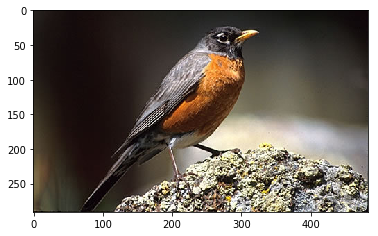

In [5]:
img_fn = PATH_TRN/'n01558993'/'n01558993_9684.JPEG'
img = open_image(img_fn)
plt.imshow(img);

### Noise

In [ ]:
# Initial image - Instead of updating model weights, we'll instead update these pixel values via backprop
noise = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(noise);

### training loop

In [ ]:
v_img = V(img, requires_grad=False)
v_noise = V(noise, requires_grad=True)

opt = torch.optim.SGD([v_noise], lr=1)

In [ ]:
def mse_replicate(input, target, opt):
    for t in range(1000):
        opt.zero_grad()
        loss = torch.nn.functional.mse_loss(input, target)*1000
        loss.backward()
        opt.step()
        
        if t%50==0: print(f'Iteration: {t}, loss: {loss.item()}')
        
#         loss.backward()                # compute gradients
#         with torch.no_grad():          # Update weights using gradient descent
#             lr=1
#             input -= lr * input.grad
#             input.grad.zero_()         # Manually zero the gradients after updating weights

In [ ]:
mse_replicate(v_noise, v_img, opt)
plt.imshow(v_noise.detach().numpy())

## Replication using perceptual loss (vgg layer)

### PIL images and torch.transforms

In [ ]:
pil_img = Image.open(img_fn)
# need to use PIL instead of open_image - size as tuple instead of int (len of numpy array)
pil_img

In [ ]:
pil_img.size

In [ ]:
noise = np.random.uniform(0, 1, size=pil_img.size[::-1]).astype(np.float32) # [::-1] => reverses tuple
pil_noise = Image.fromarray(noise, mode='RGB')

In [ ]:
pil_noise

In [ ]:
pil_noise.size

#### Transforms - center crop (288), convert to tensor to pass through VGG

In [ ]:
# not normalizing
tsfm = transforms.Compose([transforms.CenterCrop(288), transforms.ToTensor()])

In [ ]:
img_tfm = tsfm(pil_img)
img_tfm.shape

In [ ]:
noise_tfm = tsfm(pil_noise)
noise_tfm.shape

In [ ]:
# acts as a function which accepts torch tensor as parameter...
tsfm_to_pil = transforms.ToPILImage()  # still cropped to 288

In [ ]:
tsfm_to_pil(img_tfm)

In [ ]:
tsfm_to_pil(noise_tfm)

### Fastai transforms

In [15]:
_, val_tfms = tfms_from_model(vgg16, 288)

In [7]:
img_tfm = val_tfms(img)

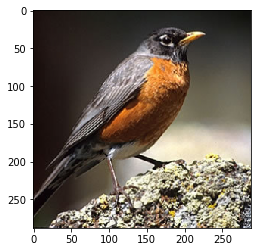

In [8]:
plt.imshow(val_tfms.denorm(np.rollaxis(img_tfm,0,3)))

### Forward Hook

In [10]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
        # when the forward method of this module (m) is called it will call self.hook_fn
    def hook_fn(self, module, input, output): self.features = output
        # stores output in the features attribute
    def close(self): self.hook.remove()

In [11]:
# m_vgg = to_gpu(vgg16(True)).eval()
m_vgg = vgg16(True).eval()  # cpu
set_trainable(m_vgg, False)
# don't waste time/memory calculating gradients

In [12]:
# find all the layers before maxpool layers -> typically the best representation available at that grid size
block_ends = [i-1 for i,o in enumerate(children(m_vgg)) if isinstance(o,nn.MaxPool2d)]
block_ends
# taking batchnorm layers w/ i-2

[5, 12, 22, 32, 42]

In [13]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])   # getting 32nd layer as module
# every forward pass, the 32nd layer's output will be stored in sf.features

### Jeremy's method

In [17]:
m_vgg(V(img_tfm[None]))         # calls forward on the vgg network (we're throwing away the output)
targ_v = sf.features.clone()  # grabbing the features we stored w/ the forward hook
targ_v.shape

torch.Size([1, 512, 36, 36])

In [17]:
# same as above but organized into a function
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)  # noise
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])       # smoothed
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)          # equalize mean, variable w/ grad
    return opt_img_v, optim.LBFGS([opt_img_v])

opt_img_v, optimizer = get_opt()

In [24]:
def mse2(input, target):
    for t in range(1,1001):
#         opt.zero_grad()
        m_vgg(input)
        out = sf.features
        loss = torch.nn.functional.mse_loss(out, target)*1000
        loss.backward()
#         opt.step()
        
        if t%50==0: print(f'Iteration: {t}, loss: {loss.item()}')
        
#         loss.backward()                # compute gradients
        with torch.no_grad():          # Update weights using gradient descent
            lr=10
            input -= lr * input.grad
            input.grad.zero_()         # Manually zero the gradients after updating weights

In [26]:
mse2(opt_img_v, targ_v)

Iteration: 50, loss: 1.2730231285095215
Iteration: 100, loss: 0.8762763142585754
Iteration: 150, loss: 0.6962924003601074
Iteration: 200, loss: 0.5970377326011658
Iteration: 250, loss: 0.5233185887336731
Iteration: 300, loss: 0.4696871340274811
Iteration: 350, loss: 0.4278629720211029
Iteration: 400, loss: 0.3941969871520996
Iteration: 450, loss: 0.3679998815059662
Iteration: 500, loss: 0.34192267060279846
Iteration: 550, loss: 0.32359662652015686
Iteration: 600, loss: 0.30690431594848633
Iteration: 650, loss: 0.2915802597999573
Iteration: 700, loss: 0.2769950032234192
Iteration: 750, loss: 0.266509085893631
Iteration: 800, loss: 0.25662413239479065
Iteration: 850, loss: 0.24610422551631927
Iteration: 900, loss: 0.23664529621601105
Iteration: 950, loss: 0.23037607967853546
Iteration: 1000, loss: 0.2217743694782257


In [ ]:
def plot_image(image):        
    ax1.clear()  
    plt.imshow(image)
    plt.draw()
    plt.pause(.02)    

In [ ]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    if n_iter%show_iter==0: print(f'Iteration: {n_iter}, loss: {loss.item()}')
    loss.backward()
    n_iter+=1
    return loss

In [ ]:
def actn_loss2(x):
    m_vgg(x)              # calls forward on network and doesn't save results
    #out = V(sf.features)  # chosen layer activations => error: variable does not require grad and does not have a grad_fn
    #out = V(sf.features, requires_grad=True)  # this avoids error but results in no drop in loss...
    out = sf.features  # remove variable to avoid above error and still optimize
    return F.mse_loss(out, targ_v)*1000

In [ ]:
max_iter = 1000
show_iter = 100
n_iter=0

while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

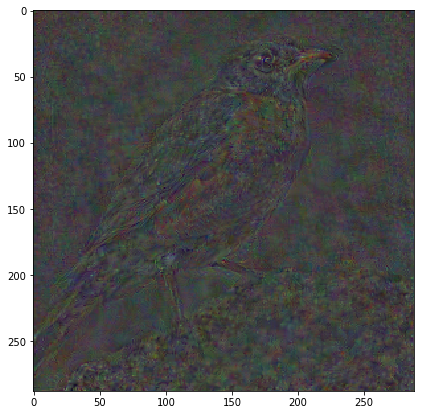

In [27]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

In [32]:
def mse3(input, target, opt):
    for t in range(1,1001):
        opt.zero_grad()
        m_vgg(input)
        out = sf.features
        loss = F.mse_loss(out, target)*1000
        loss.backward()
        opt.step()
        
        if t%100==0: print(f'Iteration: {t}, loss: {loss.item()}')
        
#         loss.backward()                # compute gradients
#         with torch.no_grad():          # Update weights using gradient descent
#             lr=10
#             input -= lr * input.grad
#             input.grad.zero_()         # Manually zero the gradients after updating weights

In [33]:
mse3(opt_img_v, targ_v, torch.optim.SGD([opt_img_v], lr=1))

Iteration: 100, loss: 0.21309952437877655
Iteration: 200, loss: 0.21164895594120026
Iteration: 300, loss: 0.2103634476661682
Iteration: 400, loss: 0.2091517150402069
Iteration: 500, loss: 0.2079918384552002
Iteration: 600, loss: 0.20686648786067963
Iteration: 700, loss: 0.2057776302099228
Iteration: 800, loss: 0.2047187238931656
Iteration: 900, loss: 0.20366087555885315
Iteration: 1000, loss: 0.20260672271251678


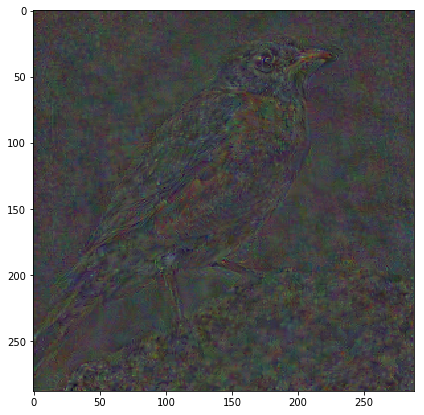

In [34]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

### Custom method

In [ ]:
opt = torch.optim.SGD([inp_v], lr=1)

In [ ]:
def mse_loss(input, target, opt):
    for t in range(1000):
        opt.zero_grad()

        # pass input through vgg to get activation layer
        m_vgg(input)
        out = sf.features

        # get mse of activation layers for input and target
        loss = torch.nn.functional.mse_loss(out, target)*1000

        # take gradient
        loss.backward()

        # update input values
        opt.step()

        if t%100==0: print(f'Iteration: {t}, loss: {loss.item()}')

In [ ]:
# ran the above w/out the function wrapper
mse_loss(inp_v, targ_v, opt)

In [ ]:
q = tsfm_to_pil(inp_v.detach()[0])
plt.figure(figsize=(7,7))
plt.imshow(q);

### Compare results from other activation layers

In [ ]:
for i in [0,1,2,4]:
    inp_v = V(noise_tfm[None], requires_grad=True)
    mse_loss(inp_v, targ_v, opt, i)
    q = tsfm_to_pil(inp_v.data[0])
    plt.figure(figsize=(7,7))
    plt.imshow(q);

## Style Match

In [6]:
style_fn = PATH/'style'/'starry_night.jpg'
style_img = open_image(style_fn)
style_img.shape, img.shape

((1520, 1919, 3), (291, 483, 3))

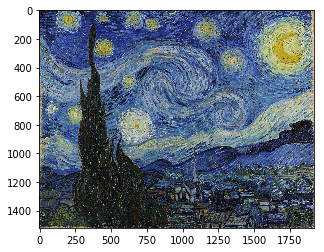

In [7]:
plt.imshow(style_img);

In [8]:
# resize style image to be same size as target image
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [9]:
style = scale_match(img, style_img)
style.shape

(291, 482, 3)

In [16]:
# same as above but organized into a function
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)  # noise
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])       # smoothed
    opt_img_v = V(val_tfms(opt_img*1.2)[None], requires_grad=True)          # equalize mean, variable w/ grad
    return opt_img_v, optim.LBFGS([opt_img_v], history_size=20)

opt_img_v, optimizer = get_opt()

In [268]:
#opt_img_v, optimizer = get_opt()
opt_img_v.max(), opt_img_v.min(), opt_img_v.mean(), opt_img_v.std()

(tensor(2.0898), tensor(-0.9528), tensor(0.7072), tensor(0.3438))

In [17]:
# save features for all block_ends -> array of activation layers
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [18]:
style_tfm = val_tfms(style)
style_tfm.max(), style_tfm.min(), style_tfm.mean(), style_tfm.std()

(2.2735724, -2.0522106, -0.20902665, 0.84974313)

In [19]:
m_vgg(V(style_tfm[None]))
targ_styles = [sf.features.clone() for sf in sfs]
[s.shape for s in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [21]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1) # flatten batch (1) and channel, height X width
        return torch.mm(x, x.t())/input.numel()*1e6
    
        #np.square(input.numel())*4  -> normalizer to mse used in the paper...
        
        # matrix multiply w/ transpose
        # normalize by dividing by number of elements (b*c*h*w)
        # results in a tiny number so we multiply by a big number (1e6) to make it more sensible

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [22]:
def style_loss(inp, targ_feats):
    m_vgg(inp)
    outs = [sf.features for sf in sfs]
    losses = [gram_mse_loss(o,s) for o,s in zip(outs, targ_feats)]
    return sum(losses)

In [23]:
def style_match(input, target, opt):
    for t in range(1,1001):
        opt.zero_grad()
        loss = style_loss(input, target)
        loss.backward()
        opt.step()
        
        if t%100==0: print(f'Iteration: {t}, loss: {loss.item()}')

In [24]:
style_match(opt_img_v, targ_styles, torch.optim.Adam([opt_img_v], lr=1))

Iteration: 100, loss: 310.6900939941406
Iteration: 200, loss: 91.99454498291016
Iteration: 300, loss: 59.367774963378906
Iteration: 400, loss: 45.3607177734375
Iteration: 500, loss: 38.00382614135742
Iteration: 600, loss: 33.277896881103516
Iteration: 700, loss: 29.491317749023438
Iteration: 800, loss: 26.39647102355957
Iteration: 900, loss: 24.245742797851562
Iteration: 1000, loss: 22.901460647583008


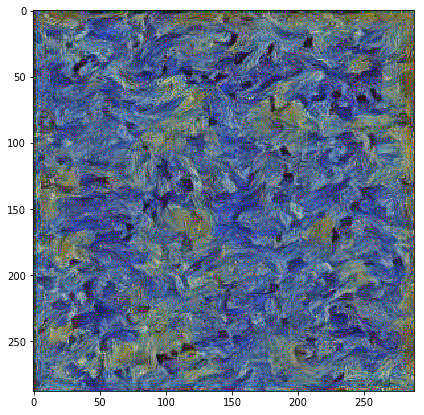

In [25]:
# With Adam & taking batchnorm layers w/ i-1 (instead of relu layers)
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

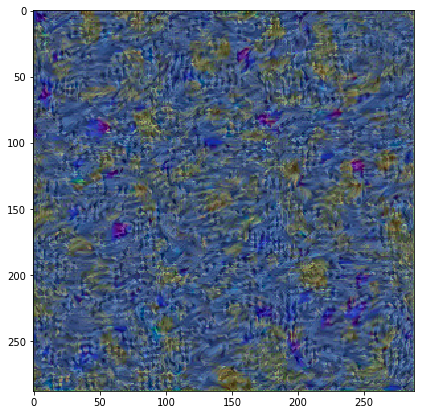

In [85]:
# With SGD & taking batchnorm layers w/ i-2 (instead of relu layers)
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);

In [ ]:
for sf in sfs: sf.close()  # close out the hook to save memory 

### Try w/ duplicated input image instead of noise

## Style Transfer

In [ ]:
opt_img_v, optimizer = get_opt()

In [ ]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [sf.features for sf in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]      # content loss
    content_loss = F.mse_loss(outs[3], targ_vs[3])                        # style losses
    style_loss = sum(losses)
    print(content_loss, style_loss)
    return (content_loss*1e5) + style_loss                                # losses added together w/ multiplier

In [ ]:
optimizer.step(partial(step,comb_loss))

In [ ]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

In [ ]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.detach()),1,4))[0]
plt.figure(figsize=(7,7))
x=np.clip(x,0,1)
plt.imshow(x);